# The Battle of Neighborhoods: Airbnb in Mexico City

![Image of Yaktocat](https://inmobiliare.com/himalaya/wp-content/uploads/2020/05/vivienda-cdmx-valor.png)


## 1. Introduction/Business Understanding

Airbnb accomodation is a booming industry with the latest rise in tourism worldwide. This means the demand for Airbnb accomodation is only going to grow further and more people would want to be in the game. 
- How should a new business person decide where to open a Airbnb?
- What factors should he look at before investing?
- Which neighborhood venues affect a user's rating for *location* of an Airbnb?

At the same time, it is difficult for a travellers, especially first-timers, to select an Airbnb from among many options. Airbnb reviews are subjective and differ from person-to-person and one cannot solely depend on them to make a decision. It is especially important to consider other aspects like price and neighborhood, which can greatly influence one's experience of the city/country.
I will try to answer the following questions 
- How does price vary with location?
- How does proximity to transportation affect airbnb rating?
- Suggest similar airbnb but which cheaper price

For this project, we will be looking at Airbnbs in Mexico, in particular, Mexico City.

This project will serve two groups of audience:
1. **Travellers:** Help them make an informed decision while choosing an Airbnb by providing an in-depth analysis of Airbnbs and their neighborhood.
2. **Business Person:** Provide useful information and models which can help them where to open their first/next Airbnb.

## 2. Data Requirements

One city will be analysed in this project : **Mexico City**.

Following are the datasets used in the project along with the reasons for choosing them:

**1. [Mexico City Airbnb's Dataset](http://insideairbnb.com/get-the-data.html)**: The data behind the Inside Airbnb site is sourced from publicly available information from the Airbnb site. The data has been analyzed, cleansed and aggregated where appropriate to faciliate public discussion.

**2. [Foursquare API](https://developer.foursquare.com/docs/api)**: This API will help me get the venues around the Airbnbs which I will use for EDA and clustering.

**3. [Mexico City Land Price](https://www.entrepreneur.com/article/342506)**: I will scrape this website to get land prices of various neighborhoods in Mexico City.

Firstly, I will use the list of Airbnbs from *Mexico City Airbnb's dataset* and use *Foursquare API* to get venues around the Airbnbs. I will then use EDA to explore the neighborhood and how it affects the price of the airbnb. I will also use the combined dataset to cluster similar airbnbs as per pricing and neighborhood. 

Second, I will combine the above data with the land price for the area in which the Airbnb is situated and them develop clustering and regression models to predict where a new Airbnb should be opened and how much should it be priced at.

## 3. Data Preparation/Pre-processing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy import OpenCage
from sklearn.cluster import KMeans
import geopy.distance

%matplotlib inline

### 3.1 Airbnb Dataset

I will read the first dataset into a dataframe. I've already downloaded the dataset as csv from Inside Airbnb. You can access the same **[here](http://insideairbnb.com/get-the-data.html)**. I'll also select the columns of interest

In [2]:
airbnb_df = pd.read_csv('data/airbnb.csv',skipinitialspace=True)
airbnb_df = airbnb_df[['name','neighbourhood_cleansed','price','host_is_superhost','latitude','longitude','room_type','number_of_reviews','review_scores_rating','review_scores_location']]
print("Number of Airbnbs in Mexico City(CDMX):", airbnb_df.shape[0])

Number of Airbnbs in Mexico City(CDMX): 21824


/Users/guillermovc/opt/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


I create a new column to indentify the airbnbs with 10 reviews or more as a way to use more reliable data.

In [3]:
airbnb_df['>10'] = airbnb_df['number_of_reviews'] >= 30

I drop the airbnbs with less than 10 reviews. Also I drop the condition column, the NaN values and reset the index.

In [4]:
indexNames = airbnb_df[ airbnb_df['>10'] == False ].index
airbnb_df.drop(indexNames , inplace=True)
airbnb_df.drop(columns=['>10'], inplace=True)
airbnb_df.dropna(inplace=True)
airbnb_df.reset_index(inplace=True)
airbnb_df.drop(columns='index', inplace=True)

In [5]:
print("Number of Airbnbs selected in Mexico City(CDMX):", airbnb_df.shape[0])

Number of Airbnbs selected in Mexico City(CDMX): 5236


I select 950 samples to cover the limitation of the Foursquare API callings, which are 99,500 per day. I save the dataframe with the samples locally and load it for further use.

In [6]:
#reduce = airbnb_df.sample(n=950)
#reduce.to_pickle("data/cdmx.pkl")

In [7]:
airbnb_df = pd.read_pickle('data/cdmx.pkl')

In [8]:
airbnb_df.sort_values(by='review_scores_location')

name  \
2029   Humongous 6BR apartment with incredible rooftop!   
3538        Full Apartment! Perfect Spot near Downtown!   
1618         Recámara cerca de corporativos de Santa Fe   
675          Best Location to explore the heart of CDMX   
2284     Departamento de lujo 60m2 equipado y amueblado   
...                                                 ...   
837                                  Roma Bohemian Vibe   
4802  El mejor (il migliore le meilleur)Loft en Coyo...   
3507                          Suites Melchor Ocampo 445   
1750                                          Easy Stay   
1500          New and great location in Condesa ap 1307   

     neighbourhood_cleansed      price  latitude  longitude        room_type  \
2029             Cuauhtémoc  $2,241.00  19.44054  -99.15112  Entire home/apt   
3538             Cuauhtémoc    $815.00  19.41948  -99.13379  Entire home/apt   
1618         Álvaro Obregón    $225.00  19.38755  -99.22395     Private room   
675              Cuauhtémoc    $679.00  19.41294  -99.14664  Entire home/apt   
2284         Miguel Hidalgo  $1,804.00  19.43425  -99.21160  Entire home/apt   
...                     ...        ...       ...        ...              ...   
837              Cuauhtémoc    $544.00  19.41942  -99.16595     Private room   
4802               Coyoacán    $702.00  19.35081  -99.14794  Entire home/apt   
3507         Miguel Hidalgo    $906.00  19.42643  -99.17627  Entire home/apt   
1750         Miguel Hidalgo    $702.00  19.43259  -99.18878     Private room   
1500             Cuauhtémoc  $1,019.00  19.42088  -99.17125  Entire home/apt   

      number_of_reviews  review_scores_rating  review_scores_location  
2029                 52                  94.0                     8.0  
3538                 95                  99.0                     9.0  
1618                 35                  98.0                     9.0  
675                  46                  97.0                     9.0  
2284                 86                  94.0                     9.0  
...                 ...                   ...                     ...  
837                  40                  94.0                    10.0  
4802                 50                  97.0                    10.0  
3507                 71                  95.0                    10.0  
1750                135                  98.0                    10.0  
1500                192                  86.0                    10.0  

[950 rows x 9 columns]

Let's check if any Airbnbs are missing location data since that is essential for our analysis.

In [83]:
print("Number of airbnbs with missing Longitude:", airbnb_df.longitude.isna().sum())
print("Num of airbnbs with missing Latitude:", airbnb_df.latitude.isna().sum())

Number of airbnbs with missing Longitude: 0
Num of airbnbs with missing Latitude: 0


Let's check the datatype of each column.

In [10]:
airbnb_df.dtypes

name                       object
neighbourhood_cleansed     object
price                      object
latitude                  float64
longitude                 float64
room_type                  object
number_of_reviews           int64
review_scores_rating      float64
review_scores_location    float64
dtype: object

Convert column "price" to float64

In [11]:
airbnb_df['price'] = airbnb_df['price'].map(lambda x: x.strip('$'))
airbnb_df.price = airbnb_df.price.apply(lambda x: x.replace(',',''))
airbnb_df.price = airbnb_df.price.astype('float')

In [12]:
airbnb_df.reset_index(inplace=True)
airbnb_df.drop(columns=['index'],inplace=True)
airbnb_df.head()

name neighbourhood_cleansed  \
0          CHIC apartment for 1 person monthly stay           Benito Juárez   
1    Private room in CDMX/Habitación Privada en CDMX             Cuauhtémoc   
2  Colonia Juárez, Precioso departamento de 2 rec...             Cuauhtémoc   
3   Nice full apartment, get the city center on foot             Cuauhtémoc   
4                                       **Zen Loft**         Miguel Hidalgo   

    price  latitude  longitude        room_type  number_of_reviews  \
0   996.0  19.37493  -99.16035  Entire home/apt                 32   
1   296.0  19.42687  -99.13442     Private room                 86   
2  1353.0  19.42689  -99.15224  Entire home/apt                 30   
3   589.0  19.44351  -99.14237  Entire home/apt                100   
4  1353.0  19.41256  -99.18836  Entire home/apt                 33   

   review_scores_rating  review_scores_location  
0                 100.0                    10.0  
1                  96.0                    10.0  
2                  96.0                    10.0  
3                  93.0                     9.0  
4                  96.0                     9.0

### 3.2 Neighborhood Data(Foursquare):¶

In [13]:
search_url = 'https://api.foursquare.com/v2/venues/search'
explore_url = 'https://api.foursquare.com/v2/venues/explore'

In [14]:
CLIENT_ID = "B2F2YEFOBWBVYG0MSN1VSWGOL2CELJ0VY02OLVLBTSTWXWAO" # your Foursquare ID
CLIENT_SECRET = "MUH2VRLB40QRF0OCMZAB4HDQZ5XELC2YWQYWG2ZFH32QUJDP" # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 30

In [15]:
sample_airbnb = airbnb_df.loc[0]
sample_airbnb['name']


'CHIC apartment for 1 person monthly stay '

In [16]:
params = dict(
  client_id=CLIENT_ID,
  client_secret=CLIENT_SECRET,
  v=VERSION,
  ll=f"{sample_airbnb.latitude}, {sample_airbnb.longitude}",
  radius=500,
  limit=100,
  sortByPopularity=1)

In [89]:
def get_recommended_venues(name, lattitude, longitude, limit=100, radius=500):
    venues = []
    params = dict(
        client_id=CLIENT_ID,
        client_secret=CLIENT_SECRET,
        v=VERSION,
        ll=f"{lattitude}, {longitude}",
        radius=radius,
        limit=50,
        sortByPopularity=1
    )
    data = requests.get(explore_url, params=params).json()['response']['groups'][0]['items']
    for v in data:
        v = v['venue']
        primary_cat = ""
        for c in v['categories']:
            if(c['primary']):
                primary_cat=c['name']
        venues.append({
            'AirbnbName':name, 
            'VenueName': v['name'], 
            'Category': primary_cat, 
            'VenueLatitue': v['location']['lat'], 
            'VenueLongtitude': v['location']['lng']
        })
    return venues

In [90]:
venue_list = []
for name, lat, long in zip(airbnb_df.name, airbnb_df.latitude, airbnb_df.longitude):
    venue_list.extend(get_recommended_venues(name, lat, long))
    i = len(venue_list)
    print(i)

50
100
132
182
231
281
331
381
431
463
513
563
613
663
713
743
759
809
859
909
929
957
1007
1057
1100
1150
1177
1227
1277
1308
1335
1385
1435
1485
1535
1585
1635
1685
1735
1785
1791
1841
1887
1927
1977
2006
2056
2070
2120
2141
2191
2241
2291
2341
2391
2410
2460
2510
2560
2608
2658
2708
2758
2799
2849
2899
2949
2999
3042
3060
3110
3160
3210
3260
3310
3360
3410
3427
3477
3527
3556
3606
3656
3706
3723
3727
3777
3827
3877
3917
3951
4001
4051
4101
4151
4201
4251
4301
4341
4391
4441
4445
4495
4518
4544
4594
4625
4675
4725
4775
4814
4864
4910
4960
5010
5060
5110
5160
5176
5226
5276
5309
5359
5409
5459
5509
5559
5609
5659
5682
5707
5757
5807
5857
5907
5957
6007
6057
6080
6130
6180
6230
6280
6310
6338
6388
6438
6462
6512
6562
6612
6662
6690
6740
6790
6840
6890
6940
6990
7026
7076
7111
7161
7211
7261
7289
7327
7371
7421
7452
7502
7552
7602
7652
7702
7752
7789
7839
7889
7939
7989
8039
8072
8122
8172
8222
8272
8322
8372
8422
8472
8522
8556
8586
8636
8650
8679
8729
8779
8829
8879
8929
8979
9029
907

In [84]:
venues_df = pd.DataFrame(venue_list)
venues_df = venues_df.rename(columns={'VenueLatitue': 'VenueLatitude', 'VenueLongtitude': 'VenueLongitude'})
venues_df.tail()

NameError: name 'venue_list' is not defined

In [93]:
cdmx_venues_df = venues_df[venues_df.AirbnbName.isin(airbnb_df.name)]

In [20]:
cdmx_venues_df.head()

AirbnbName                        VenueName  \
0  CHIC apartment for 1 person monthly stay                  Parque Arboledas   
1  CHIC apartment for 1 person monthly stay                         Starbucks   
2  CHIC apartment for 1 person monthly stay            Il Forno by 50 Friends   
3  CHIC apartment for 1 person monthly stay                Farmacia San Pablo   
4  CHIC apartment for 1 person monthly stay   Área de Perros Parque Arboledas   

             Category  VenueLatitude  VenueLongitude  
0                Park      19.379073      -99.162159  
1         Coffee Shop      19.376799      -99.162081  
2  Italian Restaurant      19.373420      -99.162346  
3            Pharmacy      19.375991      -99.161727  
4             Dog Run      19.377361      -99.162016

In [95]:
cdmx_venues_df.shape

(42060, 5)

['AirbnbName', 'VenueName', 'Category', 'VenueLatitude', 'VenueLongitude']

### 3.3 Land Price Data(Foursquare):

I use the following URL to get land prices in Mexico City, https://www.entrepreneur.com/article/342506.

In [95]:
price_df = pd.read_csv('data/price.csv')

In [19]:
price_df

Alcaldia  Metraje  Terrenos  Precio m2
0           Álvaro Obregón   695025       288      20714
1             Azcapotzalco   682413       109      17255
2            Benito Juárez   226107       487      44167
3                 Coyoacán   164882       129      27000
4    Cuajimalpa de Morelos   394801       149      13725
5               Cuauhtémoc   234167       368      45037
6        Gustavo A. Madero   373860       146      14545
7                Iztacalco    79590        64      16949
8               Iztapalapa   367266       148       9960
9   La Magdalena Contreras    99293        84      12678
10          Miguel Hidalgo   308232       341      46193
11                 Tláhuac   301334        81       7000
12                 Tlalpan  1655199       364       6667
13     Venustiano Carranza    32615        59      18251
14              Xochimilco   467972       128       6278

I clean the data 

In [97]:
price_df.drop(columns=['Unnamed: 0','Unnamed: 5','Unnamed: 6'],inplace=True)
price_df.reset_index(drop=True,inplace=True)


In [18]:
price_df

Alcaldia  Metraje  Terrenos  Precio m2
0           Álvaro Obregón   695025       288      20714
1             Azcapotzalco   682413       109      17255
2            Benito Juárez   226107       487      44167
3                 Coyoacán   164882       129      27000
4    Cuajimalpa de Morelos   394801       149      13725
5               Cuauhtémoc   234167       368      45037
6        Gustavo A. Madero   373860       146      14545
7                Iztacalco    79590        64      16949
8               Iztapalapa   367266       148       9960
9   La Magdalena Contreras    99293        84      12678
10          Miguel Hidalgo   308232       341      46193
11                 Tláhuac   301334        81       7000
12                 Tlalpan  1655199       364       6667
13     Venustiano Carranza    32615        59      18251
14              Xochimilco   467972       128       6278

### 3.4 Persist all datasets for later use.

In [788]:
#airbnb_df.to_pickle('data/airbnb_df.pkl')
#venues_df.to_pickle('data/venues.pkl')
#price_df.to_pickle('data/prices.pkl')
#cdmx_venues_df.to_pickle('data/cdmx_venues.pkl')

In [99]:
#price_df.to_pickle('data/prices.pkl')

# 4. Analysis

#### Loading data

In [3]:
airbnb_df = pd.read_pickle('data/airbnb_df.pkl')
venues_df = pd.read_pickle('data/venues.pkl')
price_df = pd.read_pickle('data/prices.pkl')
cdmx_venues_df = pd.read_pickle('data/cdmx_venues.pkl')


### 4.1 Exploratory Data Analysis

Using EDA, we will try to answer the following questions:
* How does price vary with location?
* How does proximity to transportation affect airbnb rating?

Let's first start by analyzing how many airbnbs are covered in our dataset

In [4]:
airbnb_df.shape

(946, 12)

Let's visualize all these airbnbs on the map

In [5]:
cdmx_map = folium.Map(location=(19.42847, -99.12766), zoom_start=11)

# add markers to map
for lat, lng, label in zip(airbnb_df.latitude, airbnb_df.longitude, airbnb_df.name):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#BC002D',
        fill=True,
        fill_color='#FFF',
        fill_opacity=0.75,
        parse_html=False).add_to(cdmx_map)
    
cdmx_map

### Chloropleth: Airbnb Density

Let's visualize how many airbnbs are located in each borough

In [7]:
airbnb_density = airbnb_df.groupby('neighbourhood_cleansed')['name'].count().to_frame().reset_index()
airbnb_density.columns = ['Neighborhood', 'Count']
airbnb_density.sort_values(['Count'], ascending=False)[:5]

Neighborhood  Count
4            Cuauhtémoc    502
9        Miguel Hidalgo    148
1         Benito Juárez    119
2              Coyoacán     77
12  Venustiano Carranza     21

In [8]:
import geopandas

gdf = geopandas.read_file('data/neighbourhoods.geojson')
gdf = gdf.merge(airbnb_density, left_on="neighbourhood", right_on="Neighborhood")
gdf.drop(columns='neighbourhood_group',inplace=True)
gdf.head()

neighbourhood                                           geometry  \
0           Azcapotzalco  MULTIPOLYGON (((-99.21002 19.51133, -99.20999 ...   
1               Coyoacán  MULTIPOLYGON (((-99.12189 19.35698, -99.12188 ...   
2  Cuajimalpa de Morelos  MULTIPOLYGON (((-99.25738 19.40112, -99.25698 ...   
3      Gustavo A. Madero  MULTIPOLYGON (((-99.09056 19.50955, -99.09053 ...   
4              Iztacalco  MULTIPOLYGON (((-99.05751 19.40673, -99.05752 ...   

            Neighborhood  Count  
0           Azcapotzalco      8  
1               Coyoacán     77  
2  Cuajimalpa de Morelos     13  
3      Gustavo A. Madero     10  
4              Iztacalco      8

In [9]:
import branca

colormap = branca.colormap.LinearColormap(
    colors=['#FFF9C4','#FFF176','#FFCA28','#FF9800','#D84315'],
    index=gdf['Count'].quantile([0.25, 0.5, 0.7, 0.9]),
    vmin=airbnb_density.Count.min(),
    vmax=airbnb_density.Count.max()
)

colormap.caption="Airbnb Density in Mexico City"

In [10]:
cdmx_map = folium.Map(location=(19.42847, -99.12766), zoom_start=10)

gj = folium.GeoJson(gdf,
                    style_function=lambda x: {'fillColor': colormap(x['properties']['Count']), 'color': '#000',
                                              'weight':0.25, 'fillOpacity':0.75},
                    tooltip=folium.GeoJsonTooltip(fields=['Neighborhood', 'Count'], 
                                                  aliases=['Neighborhood', 'Num of Airbnbs'], 
                                                  localize=True)
).add_to(cdmx_map)

cdmx_map

It is evident from the above map that 'Miguel Hidalgo' and 'Cuauntemoc' are host to many airbnbs. Airbnb density is highest in these neighborhoods.

Let's checkout the most expensive neighborhoods and number of airbnb in that region:

In [11]:
#price_df.drop([13],inplace=True)

In [12]:
gdf_new = gdf[['Neighborhood', 'Count']]
price_df.columns=['Neighborhood','Metraje','Terrenos','Precio m2']

In [13]:
#gdf_new['Alcaldia'] = gdf_new['Alcaldia'].replace('Álvaro Obregón', 'Alvaro Obregon')

In [14]:
cnt_price_df = gdf_new.merge(price_df, on="Neighborhood").sort_values('Precio m2', ascending=False).reset_index(drop=True)
cnt_price_df

Neighborhood  Count  Metraje  Terrenos  Precio m2
0           Miguel Hidalgo    148   308232       341      46193
1               Cuauhtémoc    502   234167       368      45037
2            Benito Juárez    119   226107       487      44167
3                 Coyoacán     77   164882       129      27000
4           Álvaro Obregón     19   695025       288      20714
5      Venustiano Carranza     21    32615        59      18251
6             Azcapotzalco      8   682413       109      17255
7                Iztacalco      8    79590        64      16949
8        Gustavo A. Madero     10   373860       146      14545
9    Cuajimalpa de Morelos     13   394801       149      13725
10  La Magdalena Contreras      4    99293        84      12678
11              Iztapalapa      4   367266       148       9960
12                 Tláhuac      1   301334        81       7000
13                 Tlalpan     11  1655199       364       6667
14              Xochimilco      1   467972       128       6278

In [15]:
cnt_price_df.sort_values(['Count', 'Precio m2'])

Neighborhood  Count  Metraje  Terrenos  Precio m2
14              Xochimilco      1   467972       128       6278
12                 Tláhuac      1   301334        81       7000
11              Iztapalapa      4   367266       148       9960
10  La Magdalena Contreras      4    99293        84      12678
7                Iztacalco      8    79590        64      16949
6             Azcapotzalco      8   682413       109      17255
8        Gustavo A. Madero     10   373860       146      14545
13                 Tlalpan     11  1655199       364       6667
9    Cuajimalpa de Morelos     13   394801       149      13725
4           Álvaro Obregón     19   695025       288      20714
5      Venustiano Carranza     21    32615        59      18251
3                 Coyoacán     77   164882       129      27000
2            Benito Juárez    119   226107       487      44167
0           Miguel Hidalgo    148   308232       341      46193
1               Cuauhtémoc    502   234167       368      45037

In [16]:
coy = (45037-27000)/27000
alva = (45037-20714)/20714
coy,alva

(0.668037037037037, 1.174229989379164)

* Coyoacán seems to be popular since it ranks fourth in the list of number of airbnbs and at the same time, it is the 4th cheapest neighbourhood in our list.
* The price of property (per sq. meter) in Coyoacán is almost 67% less than that in Cuauhtémoc, which combined with the fact that it is close Cuauhtémoc and has fewer airbnbs than Cuauhtémoc, makes it an exciting prospect for new investors.

In [17]:
airbnb_df.price.value_counts()

498.0     27
340.0     20
702.0     18
996.0     18
453.0     17
          ..
2684.0     1
729.0      1
1427.0     1
1709.0     1
4415.0     1
Name: price, Length: 315, dtype: int64

In [18]:
airbnb_df

name neighbourhood_cleansed  \
0      Private room in CDMX/Habitación Privada en CDMX             Cuauhtémoc   
1    Colonia Juárez, Precioso departamento de 2 rec...             Cuauhtémoc   
2     Nice full apartment, get the city center on foot             Cuauhtémoc   
3                                         **Zen Loft**         Miguel Hidalgo   
4             Hermoso penthouse en la Ciudad de México          Benito Juárez   
..                                                 ...                    ...   
941          Nice apart 2rooms Carso/Polanco (parking)         Miguel Hidalgo   
942   Welcome to Mexico City to this that is your home          Benito Juárez   
943                Big sunny flat Plaza Rio de Janeiro             Cuauhtémoc   
944                                     Villa Coyoacán               Coyoacán   
945          New and great location in Condesa ap 1307             Cuauhtémoc   

      price  latitude  longitude        room_type  number_of_reviews  \
0     296.0  19.42687  -99.13442     Private room                 86   
1    1353.0  19.42689  -99.15224  Entire home/apt                 30   
2     589.0  19.44351  -99.14237  Entire home/apt                100   
3    1353.0  19.41256  -99.18836  Entire home/apt                 33   
4     996.0  19.38497  -99.15212  Entire home/apt                 37   
..      ...       ...        ...              ...                ...   
941  1353.0  19.44310  -99.20064  Entire home/apt                 75   
942   770.0  19.39299  -99.16462  Entire home/apt                 57   
943  2197.0  19.41979  -99.16363  Entire home/apt                 56   
944  1200.0  19.34603  -99.16195  Entire home/apt                 39   
945  1019.0  19.42088  -99.17125  Entire home/apt                192   

     review_scores_rating  review_scores_location  distance from city center  \
0                    96.0                    10.0                   0.669503   
1                    96.0                    10.0                   2.117488   
2                    93.0                     9.0                   1.538838   
3                    96.0                     9.0                   6.224490   
4                    98.0                    10.0                   5.658334   
..                    ...                     ...                        ...   
941                  98.0                    10.0                   7.188621   
942                  95.0                    10.0                   5.512632   
943                  95.0                    10.0                   3.518101   
944                  99.0                    10.0                  10.070972   
945                  86.0                    10.0                   4.221857   

    host_is_superhost  review_scores_cleanliness  
0                   t                       10.0  
1                   t                       10.0  
2                   f                        9.0  
3                   f                       10.0  
4                   f                       10.0  
..                ...                        ...  
941                 t                        9.0  
942                 f                       10.0  
943                 f                       10.0  
944                 t                        NaN  
945                 f                        9.0  

[946 rows x 12 columns]

I calculate the for each airbnb from the city center. This as a analysis variable.

In [19]:
distance_from_center = []
for lat, long in zip(airbnb_df.latitude,airbnb_df.longitude):
    airbnb_coord = (lat,long)
    center = (19.432778, -99.133056)
    distance = geopy.distance.distance(airbnb_coord, center).km
    distance_from_center.append(distance)

    

In [20]:
airbnb_df['distance from city center'] = distance_from_center

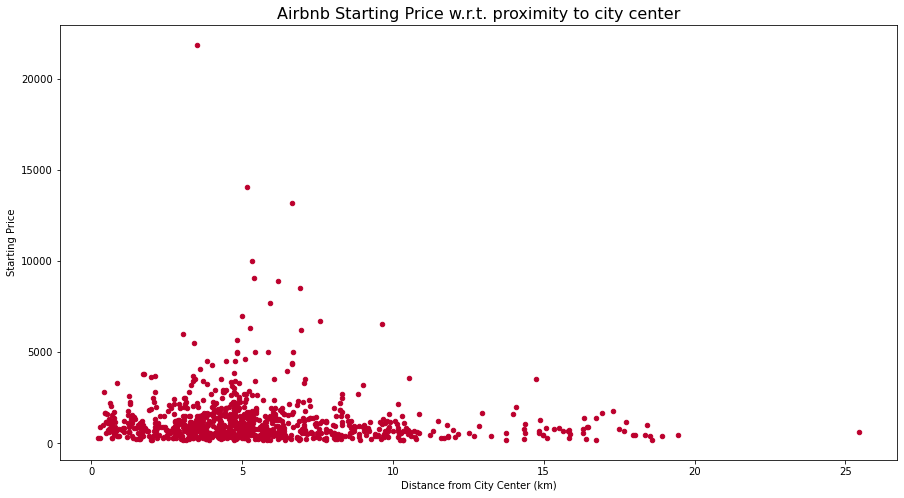

In [21]:
airbnb_df.plot(x='distance from city center', y='price', kind='scatter', figsize=(15, 8), color='#BC002D')
plt.xlabel("Distance from City Center (km)")
plt.ylabel("Starting Price")
plt.title("Airbnb Starting Price w.r.t. proximity to city center", fontsize=16)
plt.show()

We cannot see any pattern which can help us verify our assumption. If our assumption was correct, we should be seeing a curve which decreases as distance increases. However, there is no such curve visible.

Let's check the correlation score of "price" with "distance from city center".

In [22]:
airbnb_df[['price', 'distance from city center']].corr()

price  distance from city center
price                      1.000000                  -0.067402
distance from city center -0.067402                   1.000000

The correlation coefficient is very less. Hence, we can say that the starting price of airbnbs does not vary according to its distance from the city center.

#### The starting price of airbnb does not vary much depending on its distance from the city center.

#### Q. Cheap airbnb near metro stations?

We will remove rows with Empty VenueCategory

In [23]:
cdmx_venues_df.Category.replace('', np.nan, inplace=True)
cdmx_venues_df.dropna(inplace=True)
cdmx_venues_df.shape

(42060, 5)

Let's check the frequency of each Venue Category

In [24]:
cdmx_venues_df.Category.value_counts()

Mexican Restaurant         3798
Coffee Shop                2648
Taco Place                 2247
Bakery                     1637
Café                       1290
                           ... 
Nightlife Spot                1
Swiss Restaurant              1
Shoe Repair                   1
Recruiting Agency             1
State / Provincial Park       1
Name: Category, Length: 393, dtype: int64

Let's check the average number of venues per Airbnb

In [25]:
cdmx_venues_df.groupby('AirbnbName').count().describe()


VenueName    Category  VenueLatitude  VenueLongitude
count  947.000000  947.000000     947.000000      947.000000
mean    44.413939   44.413939      44.413939       44.413939
std     11.182691   11.182691      11.182691       11.182691
min      4.000000    4.000000       4.000000        4.000000
25%     44.000000   44.000000      44.000000       44.000000
50%     50.000000   50.000000      50.000000       50.000000
75%     50.000000   50.000000      50.000000       50.000000
max    116.000000  116.000000     116.000000      116.000000

Let's extract the airbnbs which are close to Metro Stations.

In [26]:
metro_airbnb = cdmx_venues_df[cdmx_venues_df.Category.str.contains('Station')]
metro_airbnb.shape

(38, 5)

In [27]:
metro_airbnb = airbnb_df[airbnb_df.name.isin(metro_airbnb.AirbnbName)]
metro_airbnb.shape

(38, 12)

In [28]:
metro_airbnb.review_scores_location.value_counts()

10.0    31
9.0      7
Name: review_scores_location, dtype: int64

In [29]:
airbnb_df.review_scores_location.value_counts()

10.0    861
9.0      84
8.0       1
Name: review_scores_location, dtype: int64

In [30]:
print("Airbnbs located near a metro/train/bus station:")
print(f"{metro_airbnb.review_scores_location.value_counts()[9]/metro_airbnb.review_scores_location.value_counts().sum()*100}% were rated with 9 score of 10")


Airbnbs located near a metro/train/bus station:
18.421052631578945% were rated with 9 score of 10


In [31]:
print("In general:")
print(f"{airbnb_df.review_scores_location.value_counts()[9]/airbnb_df.review_scores_location.value_counts().sum()*100}% were rated with 9 score of 10")

In general:
8.879492600422834% were rated with 9 score of 10


We can observe that 18% of the airbnbs near metro/train/bus stations were rated with 9 compared to only 8% in general.
This shows that there is some correlation between the proximity to mode of transportation and the overall rating of the airbnb.

#### The proportion of airbnbs rated with 9 is more near metro/bus/train stations than in general.

##### Q.Which neighborhood venues affect a user's rating for location of airbnb?

Let's do a similar analysis for a few categories and see how it affects the user rating.
We'll do similar analysis for Convenience Store, Restaurant, Bar, Shopping Mall categories

In [32]:
airbnb_near_store = airbnb_df[
    airbnb_df.name.isin(cdmx_venues_df.AirbnbName[cdmx_venues_df.Category.str.contains('store', case=False)])]

In [33]:
airbnb_near_store.review_scores_location.value_counts()

10.0    781
9.0      68
Name: review_scores_location, dtype: int64

In [34]:
print("Airbnbs located near a convenience store:")
print(f"{airbnb_near_store.review_scores_location.value_counts()[9]/airbnb_near_store.review_scores_location.value_counts().sum()*100}% were rated with 10 in location")

Airbnbs located near a convenience store:
8.00942285041225% were rated with 10 in location


In [35]:
print("In general:")
print(f"{airbnb_df.review_scores_location.value_counts()[9]/airbnb_df.review_scores_location.value_counts().sum()*100}% were rated with 9 score of 10")

In general:
8.879492600422834% were rated with 9 score of 10


#### Apparently there is not a relation between convenience store proximity and location rating.

Let's check for public parks

In [36]:
airbnb_near_park = airbnb_df[
    airbnb_df.name.isin(cdmx_venues_df.AirbnbName[cdmx_venues_df.Category.str.contains('park', case=False)])]

In [37]:
airbnb_near_park.review_scores_location.value_counts()

10.0    384
9.0      27
Name: review_scores_location, dtype: int64

In [38]:
print("Airbnbs located near a park:")
print(f"{airbnb_near_park.review_scores_location.value_counts()[10]/airbnb_near_park.review_scores_location.value_counts().sum()*100}% were rated with 10 in location")

Airbnbs located near a park:
93.43065693430657% were rated with 10 in location


In [39]:
print("In general:")
print(f"{airbnb_df.review_scores_location.value_counts()[10]/airbnb_df.review_scores_location.value_counts().sum()*100}% were rated with 9 score of 10")

In general:
91.01479915433404% were rated with 9 score of 10


Let's see about historic sites

Airbnbs with proximity to a park don't affect rating.

In [40]:
airbnb_near_hist = airbnb_df[
    airbnb_df.name.isin(cdmx_venues_df.AirbnbName[cdmx_venues_df.Category.str.contains('Historic Site', case=False)])]

In [41]:
airbnb_near_hist.review_scores_location.value_counts()

10.0    77
9.0     19
8.0      1
Name: review_scores_location, dtype: int64

In [42]:
print("Airbnbs located near a historic site:")
print(f"{airbnb_near_hist.review_scores_location.value_counts()[10]/airbnb_near_hist.review_scores_location.value_counts().sum()*100}% were rated with 10 in location")

Airbnbs located near a historic site:
79.38144329896907% were rated with 10 in location


In [43]:
print("In general:")
print(f"{airbnb_df.review_scores_location.value_counts()[10]/airbnb_df.review_scores_location.value_counts().sum()*100}% were rated with 9 score of 10")

In general:
91.01479915433404% were rated with 9 score of 10


Let's see about museums

In [44]:
airbnb_near_museum = airbnb_df[
    airbnb_df.name.isin(cdmx_venues_df.AirbnbName[cdmx_venues_df.Category.str.contains('Museum', case=False)])]

In [45]:
airbnb_near_museum.review_scores_location.value_counts()

10.0    157
9.0      29
8.0       1
Name: review_scores_location, dtype: int64

In [46]:
print("Airbnbs located near a historic site:")
print(f"{airbnb_near_museum.review_scores_location.value_counts()[10]/airbnb_near_museum.review_scores_location.value_counts().sum()*100}% were rated 10 in location")

Airbnbs located near a historic site:
83.9572192513369% were rated 10 in location


# 4.2 Clustering

Now, we will cluster the airbnbs twice. Once depending on the different rating parameters and one based on their neighborhood.

Consider the following case, that a traveller has selected an airbnb, but he finds that it is full! What options does he have? He/She can either go for a airbnb which is similar in rating and price to the one he/she has selected. Or he/she can consider airbnbs which boast similar neighborhood to the selected one.

We will help traveller in both cases

### 4.2.1 Clustering based on rating parameters



In [47]:
X = airbnb_df[['price','distance from city center','review_scores_location','review_scores_cleanliness']]
X['review_scores_cleanliness'] = X['review_scores_cleanliness'].fillna(9)

In [48]:
def get_inertia(n_clusters):
    km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=15, random_state=8)
    km.fit(X)
    return km.inertia_

Text(0, 0.5, 'Error')

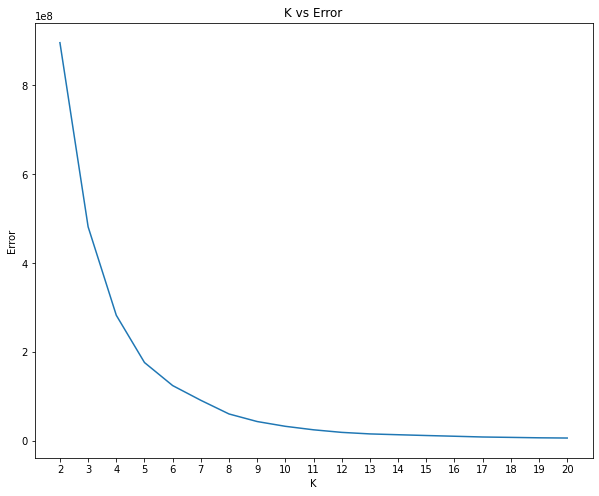

In [49]:
scores = [get_inertia(x) for x in range(2, 21)]
plt.figure(figsize=[10, 8])
sns.lineplot(x=range(2, 21), y=scores)
plt.title("K vs Error")
plt.xticks(range(2, 21))
plt.xlabel("K")
plt.ylabel("Error")

In [50]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)


KMeans(n_clusters=7)

In [51]:
airbnb_df['RatingCluster'] = kmeans.labels_


In [52]:
cdmx_map = folium.Map(location=(19.42847, -99.12766), zoom_start=10)

# set color scheme for the clusters
x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(9)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
markers_colors = []
for lat, lng, name, cluster in zip(airbnb_df.latitude, airbnb_df.longitude, airbnb_df.name, kmeans.labels_):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color='#FFF',
        fill_opacity=0.75,
        parse_html=False).add_to(cdmx_map)
    
cdmx_map

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. But we won't be doing it for all. We'll compare 0, 2, 4, 5 clusters for the sake of brevity

### Cluster 1

In [53]:
airbnb_df[airbnb_df.RatingCluster == 1].describe()

price   latitude  longitude  number_of_reviews  \
count      2.000000   2.000000   2.000000           2.000000   
mean   13597.500000  19.428830 -99.186260         125.500000   
std      627.203715   0.022924   0.012657          78.488853   
min    13154.000000  19.412620 -99.195210          70.000000   
25%    13375.750000  19.420725 -99.190735          97.750000   
50%    13597.500000  19.428830 -99.186260         125.500000   
75%    13819.250000  19.436935 -99.181785         153.250000   
max    14041.000000  19.445040 -99.177310         181.000000   

       review_scores_rating  review_scores_location  \
count              2.000000                2.000000   
mean              97.000000                9.500000   
std                2.828427                0.707107   
min               95.000000                9.000000   
25%               96.000000                9.250000   
50%               97.000000                9.500000   
75%               98.000000                9.750000   
max               99.000000               10.000000   

       distance from city center  review_scores_cleanliness  RatingCluster  
count                   2.000000                   2.000000            2.0  
mean                    5.911119                   9.500000            1.0  
std                     1.068437                   0.707107            0.0  
min                     5.155620                   9.000000            1.0  
25%                     5.533369                   9.250000            1.0  
50%                     5.911119                   9.500000            1.0  
75%                     6.288868                   9.750000            1.0  
max                     6.666618                  10.000000            1.0

#### Low price. Not far from city center. Very good cleanliness and location rating. Very good score rating.

### Cluster 2

In [54]:
airbnb_df[airbnb_df.RatingCluster == 2].describe()

price    latitude   longitude  number_of_reviews  \
count  474.000000  474.000000  474.000000         474.000000   
mean   510.736287   19.402973  -99.162098          79.286920   
std    185.179783    0.040468    0.031687          51.708423   
min    180.000000   19.259090  -99.335020          30.000000   
25%    361.250000   19.384955  -99.175258          41.000000   
50%    498.000000   19.411305  -99.163270          65.000000   
75%    657.000000   19.430733  -99.147248         100.750000   
max    866.000000   19.523550  -99.050580         380.000000   

       review_scores_rating  review_scores_location  \
count            474.000000              474.000000   
mean              96.116034                9.898734   
std                3.041857                0.301999   
min               81.000000                9.000000   
25%               95.000000               10.000000   
50%               97.000000               10.000000   
75%               98.000000               10.000000   
max              100.000000               10.000000   

       distance from city center  review_scores_cleanliness  RatingCluster  
count                 474.000000                 474.000000          474.0  
mean                    6.002589                   9.694093            2.0  
std                     3.907647                   0.479260            0.0  
min                     0.224876                   8.000000            2.0  
25%                     3.555672                   9.000000            2.0  
50%                     5.043512                  10.000000            2.0  
75%                     7.698715                  10.000000            2.0  
max                    25.454354                  10.000000            2.0

#### High price. Not far from city center. Very good cleanliness and location rating. Very good score rating.

### Cluster 4

In [55]:
airbnb_df[airbnb_df.RatingCluster == 4].describe()

price   latitude  longitude  number_of_reviews  \
count     11.000000  11.000000  11.000000          11.000000   
mean    7536.909091  19.414274 -99.179595          72.272727   
std     1372.378552   0.026811   0.019502          56.598747   
min     6001.000000  19.348920 -99.205250          31.000000   
25%     6430.000000  19.408025 -99.195230          42.000000   
50%     6975.000000  19.421660 -99.179160          49.000000   
75%     8699.000000  19.434260 -99.166400          74.000000   
max    10008.000000  19.437220 -99.144490         226.000000   

       review_scores_rating  review_scores_location  \
count             11.000000               11.000000   
mean              96.636364                9.909091   
std                2.203303                0.301511   
min               92.000000                9.000000   
25%               96.000000               10.000000   
50%               97.000000               10.000000   
75%               97.500000               10.000000   
max              100.000000               10.000000   

       distance from city center  review_scores_cleanliness  RatingCluster  
count                  11.000000                  11.000000           11.0  
mean                    6.107801                   9.818182            4.0  
std                     1.691008                   0.404520            0.0  
min                     3.036689                   9.000000            4.0  
25%                     5.287375                  10.000000            4.0  
50%                     5.911039                  10.000000            4.0  
75%                     6.933761                  10.000000            4.0  
max                     9.641253                  10.000000            4.0

#### Traits: Medium Cost. Not so far from city center. Very high cleanliness and location rating. High score rating.

### Cluster 3

In [56]:
airbnb_df[airbnb_df.RatingCluster == 3].describe()

price   latitude  longitude  number_of_reviews  \
count    40.000000  40.000000  40.000000          40.000000   
mean   3965.500000  19.416342 -99.172655          73.375000   
std     697.740456   0.023443   0.018093          45.282412   
min    3148.000000  19.336150 -99.229690          30.000000   
25%    3397.000000  19.411575 -99.177060          43.750000   
50%    3668.500000  19.416880 -99.171155          56.000000   
75%    4512.250000  19.431317 -99.161915          91.000000   
max    5662.000000  19.443710 -99.134590         227.000000   

       review_scores_rating  review_scores_location  \
count             40.000000               40.000000   
mean              97.250000                9.900000   
std                1.970943                0.303822   
min               92.000000                9.000000   
25%               96.000000               10.000000   
50%               97.500000               10.000000   
75%               99.000000               10.000000   
max              100.000000               10.000000   

       distance from city center  review_scores_cleanliness  RatingCluster  
count                  40.000000                  40.000000           40.0  
mean                    4.966905                   9.900000            3.0  
std                     2.485285                   0.303822            0.0  
min                     0.857889                   9.000000            3.0  
25%                     3.568835                  10.000000            3.0  
50%                     4.737780                  10.000000            3.0  
75%                     5.917485                  10.000000            3.0  
max                    14.746514                  10.000000            3.0

#### High price. Very good score rating. Very good location and cleanliness ratings. Close to city center

### Cluster 5

In [57]:
airbnb_df[airbnb_df.RatingCluster == 5].describe()

price  latitude  longitude  number_of_reviews  review_scores_rating  \
count      1.0   1.00000    1.00000                1.0                   1.0   
mean   21854.0  19.42011  -99.16347               56.0                  96.0   
std        NaN       NaN        NaN                NaN                   NaN   
min    21854.0  19.42011  -99.16347               56.0                  96.0   
25%    21854.0  19.42011  -99.16347               56.0                  96.0   
50%    21854.0  19.42011  -99.16347               56.0                  96.0   
75%    21854.0  19.42011  -99.16347               56.0                  96.0   
max    21854.0  19.42011  -99.16347               56.0                  96.0   

       review_scores_location  distance from city center  \
count                     1.0                   1.000000   
mean                     10.0                   3.488379   
std                       NaN                        NaN   
min                      10.0                   3.488379   
25%                      10.0                   3.488379   
50%                      10.0                   3.488379   
75%                      10.0                   3.488379   
max                      10.0                   3.488379   

       review_scores_cleanliness  RatingCluster  
count                        1.0            1.0  
mean                        10.0            5.0  
std                          NaN            NaN  
min                         10.0            5.0  
25%                         10.0            5.0  
50%                         10.0            5.0  
75%                         10.0            5.0  
max                         10.0            5.0

#### Very High Price. Very good score rating. Very good location and cleanliness. Close from city center

### Cluster 6

In [58]:
airbnb_df[airbnb_df.RatingCluster == 6].describe()

price    latitude   longitude  number_of_reviews  \
count   106.000000  106.000000  106.000000         106.000000   
mean   2211.509434   19.418435  -99.171128          90.056604   
std     352.826067    0.020493    0.021273          60.482950   
min    1743.000000   19.305850  -99.277110          30.000000   
25%    1925.000000   19.413563  -99.176995          44.250000   
50%    2151.000000   19.419915  -99.170745          71.500000   
75%    2472.250000   19.432602  -99.159440         124.000000   
max    3057.000000   19.442970  -99.089750         394.000000   

       review_scores_rating  review_scores_location  \
count            106.000000              106.000000   
mean              96.820755                9.924528   
std                2.357550                0.299145   
min               89.000000                8.000000   
25%               96.000000               10.000000   
50%               97.000000               10.000000   
75%               99.000000               10.000000   
max              100.000000               10.000000   

       distance from city center  review_scores_cleanliness  RatingCluster  
count                 106.000000                 106.000000          106.0  
mean                    4.766082                   9.839623            6.0  
std                     2.426821                   0.368699            0.0  
min                     0.403458                   9.000000            6.0  
25%                     3.269471                  10.000000            6.0  
50%                     4.713196                  10.000000            6.0  
75%                     5.449577                  10.000000            6.0  
max                    17.296865                  10.000000            6.0

#### Very High Price. Very good score rating. Very good location and cleanliness. Not so far from city center

### Cluster 0

In [59]:
airbnb_df[airbnb_df.RatingCluster == 0].describe()

price    latitude   longitude  number_of_reviews  \
count   312.000000  312.000000  312.000000         312.000000   
mean   1225.842949   19.413441  -99.169408          83.134615   
std     241.678757    0.029886    0.023917          60.139504   
min     878.000000   19.280330  -99.289080          30.000000   
25%     996.000000   19.406230  -99.178285          39.000000   
50%    1200.000000   19.420300  -99.167590          58.000000   
75%    1431.000000   19.432482  -99.156570         109.000000   
max    1709.000000   19.488970  -99.082530         354.000000   

       review_scores_rating  review_scores_location  \
count            312.000000              312.000000   
mean              95.791667                9.923077   
std                2.971168                0.266897   
min               83.000000                9.000000   
25%               94.000000               10.000000   
50%               97.000000               10.000000   
75%               98.000000               10.000000   
max              100.000000               10.000000   

       distance from city center  review_scores_cleanliness  RatingCluster  
count                 312.000000                 311.000000          312.0  
mean                    5.128734                   9.749196            0.0  
std                     3.175796                   0.469857            0.0  
min                     0.282865                   8.000000            0.0  
25%                     3.300989                  10.000000            0.0  
50%                     4.693809                  10.000000            0.0  
75%                     6.199222                  10.000000            0.0  
max                    18.407900                  10.000000            0.0

#### Medium High Cost. Good score rating. Very good location and cleanliness rating. Close to city centre

Now suppose that I want to stay at "**Zen Loft**". However, when I go to book, it shows that it doesn't have any spots available! Fortunately, I can now use the cluster result to find a airbnb similar to **Zen Loft**. Let's see what options do I have!

In [60]:
airbnb_df.loc[3]

name                            **Zen Loft**
neighbourhood_cleansed        Miguel Hidalgo
price                                   1353
latitude                             19.4126
longitude                           -99.1884
room_type                    Entire home/apt
number_of_reviews                         33
review_scores_rating                      96
review_scores_location                     9
distance from city center            6.22449
host_is_superhost                          f
review_scores_cleanliness                 10
RatingCluster                              0
Name: 3, dtype: object

**Zen Loft** RatingCluster is 5. Let's see what options do I have.

In [61]:
airbnb_df[airbnb_df.RatingCluster == 0].sort_values(['price'], ascending=False)[:5]

name neighbourhood_cleansed  \
797    Amazing & Luxury Unit in Polanco with a balcony         Miguel Hidalgo   
257                2BDR BOUTIQUE IN THE❤️HISTORICCENTR             Cuauhtémoc   
775         ELEGANT 2BED/1BATH APARTMENT AT LA CONDESA             Cuauhtémoc   
940  Penthouse Roma Norte/Condesa. EVERYTHING YOU NEED             Cuauhtémoc   
198   Unbeatable location! 2BR apt next to Reforma Av.             Cuauhtémoc   

      price  latitude  longitude        room_type  number_of_reviews  \
797  1709.0  19.42889  -99.19306  Entire home/apt                 43   
257  1699.0  19.43165  -99.14011  Entire home/apt                241   
775  1699.0  19.40841  -99.17040  Entire home/apt                 30   
940  1699.0  19.42024  -99.17153  Entire home/apt                153   
198  1699.0  19.42874  -99.17169  Entire home/apt                 52   

     review_scores_rating  review_scores_location  distance from city center  \
797                  96.0                    10.0                   6.316184   
257                  88.0                    10.0                   0.751241   
775                  91.0                    10.0                   4.760119   
940                  88.0                    10.0                   4.272300   
198                  95.0                    10.0                   4.081818   

    host_is_superhost  review_scores_cleanliness  RatingCluster  
797                 t                       10.0              0  
257                 f                       10.0              0  
775                 f                        9.0              0  
940                 f                        9.0              0  
198                 t                       10.0              0

#### We can do the same for the other 6 clusters as well, but we are not doing that now.


## 4.2.2 Clustering based on neighborhood

Now, we will cluster the same airbnbs. But this time, we will not use ratings or price instead we will use the neighborhood data and see which airbnbs have similar surroundings. Some travellers focus more on the location of a place rather than the price or ratings. This can be useful for them.

We will do one-hot encoding for the Category column to convert them to features

In [62]:
category_1hot = pd.get_dummies(cdmx_venues_df.Category)
category_1hot['AirbnbName'] = cdmx_venues_df.AirbnbName

# move neighborhood column to the first column
fixed_columns = [category_1hot.columns[-1]] + list(category_1hot.columns[:-1])
category_1hot = category_1hot[fixed_columns]
category_1hot.head()

AirbnbName  ATM  Accessories Store  \
0  CHIC apartment for 1 person monthly stay     0                  0   
1  CHIC apartment for 1 person monthly stay     0                  0   
2  CHIC apartment for 1 person monthly stay     0                  0   
3  CHIC apartment for 1 person monthly stay     0                  0   
4  CHIC apartment for 1 person monthly stay     0                  0   

   Advertising Agency  Airport  Airport Gate  Airport Lounge  Airport Service  \
0                   0        0             0               0                0   
1                   0        0             0               0                0   
2                   0        0             0               0                0   
3                   0        0             0               0                0   
4                   0        0             0               0                0   

   American Restaurant  Amphitheater  ...  Watch Shop  Water Park  Wine Bar  \
0                    0             0  ...           0           0         0   
1                    0             0  ...           0           0         0   
2                    0             0  ...           0           0         0   
3                    0             0  ...           0           0         0   
4                    0             0  ...           0           0         0   

   Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  \
0          0       0            0              0            0   
1          0       0            0              0            0   
2          0       0            0              0            0   
3          0       0            0              0            0   
4          0       0            0              0            0   

   Yucatecan Restaurant  Zoo  
0                     0    0  
1                     0    0  
2                     0    0  
3                     0    0  
4                     0    0  

[5 rows x 394 columns]

In [63]:
category_1hot.shape

(42060, 394)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.


In [64]:
category_1hot = category_1hot.groupby('AirbnbName').mean().reset_index()
category_1hot.head()

AirbnbName  ATM  Accessories Store  \
0      "Departamento con su vecino, el árbol"  0.0                0.0   
1                 "Hospedaje Suite Zona Rosa"  0.0                0.0   
2  "La Amapola" Beautiful Apartment - Terrace  0.0                0.0   
3          "La Españolita" gem in Mexico City  0.0                0.0   
4     "Viva la Vida": art, style and comfort.  0.0                0.0   

   Advertising Agency  Airport  Airport Gate  Airport Lounge  Airport Service  \
0                 0.0      0.0           0.0             0.0              0.0   
1                 0.0      0.0           0.0             0.0              0.0   
2                 0.0      0.0           0.0             0.0              0.0   
3                 0.0      0.0           0.0             0.0              0.0   
4                 0.0      0.0           0.0             0.0              0.0   

   American Restaurant  Amphitheater  ...  Watch Shop  Water Park  Wine Bar  \
0                 0.04           0.0  ...         0.0         0.0       0.0   
1                 0.02           0.0  ...         0.0         0.0       0.0   
2                 0.02           0.0  ...         0.0         0.0       0.0   
3                 0.00           0.0  ...         0.0         0.0       0.0   
4                 0.00           0.0  ...         0.0         0.0       0.0   

   Wine Shop  Winery  Wings Joint  Women's Store  Yoga Studio  \
0        0.0     0.0         0.00            0.0          0.0   
1        0.0     0.0         0.00            0.0          0.0   
2        0.0     0.0         0.00            0.0          0.0   
3        0.0     0.0         0.02            0.0          0.0   
4        0.0     0.0         0.00            0.0          0.0   

   Yucatecan Restaurant  Zoo  
0                   0.0  0.0  
1                   0.0  0.0  
2                   0.0  0.0  
3                   0.0  0.0  
4                   0.0  0.0  

[5 rows x 394 columns]

Let's see few Airbnb along with the top 5 most common venues

In [65]:
num_top_venues = 5

for nbrhood in category_1hot.AirbnbName[:5]:
    print("---- "+nbrhood+" ----")
    temp = category_1hot[category_1hot.AirbnbName == nbrhood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- "Departamento con su vecino, el árbol" ----
                venue  freq
0  Mexican Restaurant  0.12
1         Coffee Shop  0.10
2          Taco Place  0.06
3  Italian Restaurant  0.04
4          Steakhouse  0.04


---- "Hospedaje Suite Zona Rosa" ----
                 venue  freq
0          Coffee Shop  0.18
1   Mexican Restaurant  0.10
2                Hotel  0.08
3  Japanese Restaurant  0.06
4          Pizza Place  0.04


---- "La Amapola" Beautiful Apartment - Terrace ----
                venue  freq
0         Coffee Shop  0.10
1  Seafood Restaurant  0.08
2            Pharmacy  0.04
3  Mexican Restaurant  0.04
4              Bakery  0.04


---- "La Españolita" gem in Mexico City ----
                    venue  freq
0             Coffee Shop  0.12
1      Mexican Restaurant  0.10
2                   Diner  0.04
3  Argentinian Restaurant  0.04
4       French Restaurant  0.04


---- "Viva la Vida": art, style and comfort. ----
            venue  freq
0      Art Museum  0.09
1   His

In [66]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [67]:
indicators = ['st', 'nd', 'rd']
num_top_venues = 10

# create columns according to number of top venues
columns = ['AirbnbName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nbr_venues_sorted_df = pd.DataFrame(columns=columns)
nbr_venues_sorted_df['AirbnbName'] = category_1hot.AirbnbName

for ind in np.arange(category_1hot.shape[0]):
    nbr_venues_sorted_df.iloc[ind, 1:] = return_most_common_venues(category_1hot.iloc[ind, :], num_top_venues)

nbr_venues_sorted_df.head()

AirbnbName 1st Most Common Venue  \
0      "Departamento con su vecino, el árbol"    Mexican Restaurant   
1                 "Hospedaje Suite Zona Rosa"           Coffee Shop   
2  "La Amapola" Beautiful Apartment - Terrace           Coffee Shop   
3          "La Españolita" gem in Mexico City           Coffee Shop   
4     "Viva la Vida": art, style and comfort.            Art Museum   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Coffee Shop            Taco Place        Breakfast Spot   
1    Mexican Restaurant                 Hotel   Japanese Restaurant   
2    Seafood Restaurant        Breakfast Spot            Taco Place   
3    Mexican Restaurant            Restaurant                  Café   
4         Historic Site                Museum        History Museum   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0    Chinese Restaurant            Steakhouse   Japanese Restaurant   
1           Pizza Place                Lounge          Cocktail Bar   
2  Gym / Fitness Center            Steakhouse                Bakery   
3         Shopping Mall                 Diner        Clothing Store   
4         Jewelry Store          Concert Hall            Restaurant   

  8th Most Common Venue   9th Most Common Venue 10th Most Common Venue  
0    Italian Restaurant               BBQ Joint    American Restaurant  
1     Korean Restaurant      Italian Restaurant             Steakhouse  
2              Pharmacy      Mexican Restaurant                Brewery  
3     French Restaurant  Argentinian Restaurant              Nightclub  
4                Hostel          Cosmetics Shop       Toy / Game Store

#### Clustering Neighborhoods

Let's cluster neighborhoods into 4 types based on venue categories.

In [68]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=15, random_state=8)
X = category_1hot.drop(['AirbnbName'], axis=1)
X.head()

ATM  Accessories Store  Advertising Agency  Airport  Airport Gate  \
0  0.0                0.0                 0.0      0.0           0.0   
1  0.0                0.0                 0.0      0.0           0.0   
2  0.0                0.0                 0.0      0.0           0.0   
3  0.0                0.0                 0.0      0.0           0.0   
4  0.0                0.0                 0.0      0.0           0.0   

   Airport Lounge  Airport Service  American Restaurant  Amphitheater  \
0             0.0              0.0                 0.04           0.0   
1             0.0              0.0                 0.02           0.0   
2             0.0              0.0                 0.02           0.0   
3             0.0              0.0                 0.00           0.0   
4             0.0              0.0                 0.00           0.0   

   Antique Shop  ...  Watch Shop  Water Park  Wine Bar  Wine Shop  Winery  \
0           0.0  ...         0.0         0.0       0.0        0.0     0.0   
1           0.0  ...         0.0         0.0       0.0        0.0     0.0   
2           0.0  ...         0.0         0.0       0.0        0.0     0.0   
3           0.0  ...         0.0         0.0       0.0        0.0     0.0   
4           0.0  ...         0.0         0.0       0.0        0.0     0.0   

   Wings Joint  Women's Store  Yoga Studio  Yucatecan Restaurant  Zoo  
0         0.00            0.0          0.0                   0.0  0.0  
1         0.00            0.0          0.0                   0.0  0.0  
2         0.00            0.0          0.0                   0.0  0.0  
3         0.02            0.0          0.0                   0.0  0.0  
4         0.00            0.0          0.0                   0.0  0.0  

[5 rows x 393 columns]

In [69]:
kmeans.fit(X)

KMeans(max_iter=15, n_clusters=4, random_state=8)

In [70]:
nbr_venues_sorted_df['Cluster'] = kmeans.labels_
nbr_venues_sorted_df.rename(columns={'AirbnbName': 'name'}, inplace=True)

In [71]:
airbnb_df_merged = pd.merge(airbnb_df, nbr_venues_sorted_df, on='name')
airbnb_df_merged.head()

name neighbourhood_cleansed  \
0    Private room in CDMX/Habitación Privada en CDMX             Cuauhtémoc   
1  Colonia Juárez, Precioso departamento de 2 rec...             Cuauhtémoc   
2   Nice full apartment, get the city center on foot             Cuauhtémoc   
3                                       **Zen Loft**         Miguel Hidalgo   
4           Hermoso penthouse en la Ciudad de México          Benito Juárez   

    price  latitude  longitude        room_type  number_of_reviews  \
0   296.0  19.42687  -99.13442     Private room                 86   
1  1353.0  19.42689  -99.15224  Entire home/apt                 30   
2   589.0  19.44351  -99.14237  Entire home/apt                100   
3  1353.0  19.41256  -99.18836  Entire home/apt                 33   
4   996.0  19.38497  -99.15212  Entire home/apt                 37   

   review_scores_rating  review_scores_location  distance from city center  \
0                  96.0                    10.0                   0.669503   
1                  96.0                    10.0                   2.117488   
2                  93.0                     9.0                   1.538838   
3                  96.0                     9.0                   6.224490   
4                  98.0                    10.0                   5.658334   

   ... 2nd Most Common Venue  3rd Most Common Venue  4th Most Common Venue  \
0  ...        Clothing Store    Arts & Crafts Store                  Plaza   
1  ...                   Bar              Speakeasy     Italian Restaurant   
2  ...            Taco Place                    Bar                    Gym   
3  ...            Restaurant                 Museum            Pizza Place   
4  ...                Bakery                   Café             Food Truck   

  5th Most Common Venue 6th Most Common Venue    7th Most Common Venue  \
0              Pharmacy                  Café         Department Store   
1     German Restaurant    Mexican Restaurant                Cafeteria   
2                Bakery    Seafood Restaurant                  Gay Bar   
3           Art Gallery    Mexican Restaurant              Coffee Shop   
4    Seafood Restaurant          Burger Joint  Health & Beauty Service   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue Cluster  
0            Restaurant            Taco Place                 Bakery       3  
1               Stadium                Bakery                 Market       0  
2        Breakfast Spot               Brewery     Chinese Restaurant       2  
3           Yoga Studio                   Gym            Music Venue       2  
4            Restaurant        Gymnastics Gym            Coffee Shop       0  

[5 rows x 24 columns]

Finally, let's visualize the resulting clusters

In [72]:
# create map
cdmx_map = folium.Map(location=(19.42847, -99.12766), zoom_start=10)

# set color scheme for the clusters
x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(9)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(airbnb_df_merged['latitude'], airbnb_df_merged['longitude'], airbnb_df_merged['name'], airbnb_df_merged['Cluster']):
    label = folium.Popup(str(poi) + ' (Cluster ' + str(cluster) + ')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color='#FFF',
        fill_opacity=0.7).add_to(cdmx_map)

In [73]:
cdmx_map

#### Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

### Cluster 0

In [74]:
airbnb_df_merged.loc[airbnb_df_merged['Cluster'] == 0, airbnb_df_merged.columns[[0] + list(range(13, airbnb_df_merged.shape[1]))]][:5]

name 1st Most Common Venue  \
1   Colonia Juárez, Precioso departamento de 2 rec...           Art Gallery   
4            Hermoso penthouse en la Ciudad de México            Taco Place   
9   Beautiful apartment full of light in Condesa/Roma    Mexican Restaurant   
10  Coyoacan 2 level cozy apartment 3BR / 3BA+Terrace    Mexican Restaurant   
17  Sumérgete en arte en departamento de lujo con ...           Coffee Shop   

   2nd Most Common Venue 3rd Most Common Venue          4th Most Common Venue  \
1                    Bar             Speakeasy             Italian Restaurant   
4                 Bakery                  Café                     Food Truck   
9                 Bakery                  Park             Seafood Restaurant   
10           Coffee Shop                Bakery  Vegetarian / Vegan Restaurant   
17                Bakery        Ice Cream Shop                     Taco Place   

   5th Most Common Venue     6th Most Common Venue    7th Most Common Venue  \
1      German Restaurant        Mexican Restaurant                Cafeteria   
4     Seafood Restaurant              Burger Joint  Health & Beauty Service   
9            Coffee Shop  Mediterranean Restaurant                Nightclub   
10    Athletics & Sports            Sandwich Place               Taco Place   
17          Burger Joint                Restaurant                  Dog Run   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  Cluster  
1                Stadium                Bakery                 Market        0  
4             Restaurant        Gymnastics Gym            Coffee Shop        0  
9            Snack Place            Taco Place     Frozen Yogurt Shop        0  
10                   Gym           Supermarket            Pizza Place        0  
17                  Café           Yoga Studio     Mexican Restaurant        0

In [75]:
airbnb_df_merged.loc[airbnb_df_merged['Cluster'] == 0]['1st Most Common Venue'].value_counts().head(7)

Coffee Shop           53
Mexican Restaurant    42
Ice Cream Shop        40
Bakery                37
Taco Place            32
Seafood Restaurant    17
Restaurant            13
Name: 1st Most Common Venue, dtype: int64

#### 1st Cluster Properties: Variety of places. Coffee Shops, Restaurants, Ice Cream Shops and Bakerys

### Cluster 1

In [76]:
airbnb_df_merged.loc[airbnb_df_merged['Cluster'] == 1, airbnb_df_merged.columns[[0] + list(range(13, airbnb_df_merged.shape[1]))]][:5]

name 1st Most Common Venue  \
5   Great 1Br1Ba Studio in Angel-Reforma w FreePar...           Coffee Shop   
6                 Hermoso departamento, zona céntrica            Taco Place   
7      Exelent location. King bed , private bathroom,           Coffee Shop   
11   #CamPeChe 1. Unique space with enormous terrace.           Coffee Shop   
13             Cozy and Centric TWO Bedroom Apartment    Mexican Restaurant   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
5    Japanese Restaurant                 Hotel                  Café   
6            Coffee Shop    Mexican Restaurant        Ice Cream Shop   
7     Mexican Restaurant        Sandwich Place            Taco Place   
11    Mexican Restaurant            Taco Place                  Café   
13           Coffee Shop   Japanese Restaurant  Gym / Fitness Center   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
5     Mexican Restaurant                Lounge            Taco Place   
6             Restaurant               Theater        Sandwich Place   
7    Japanese Restaurant    Italian Restaurant        Breakfast Spot   
11                Bakery        Sandwich Place    Seafood Restaurant   
13           Flea Market    Seafood Restaurant             BBQ Joint   

   8th Most Common Venue      9th Most Common Venue 10th Most Common Venue  \
5       Asian Restaurant  South American Restaurant         Sandwich Place   
6            Art Gallery                        Bar                  Plaza   
7            Pizza Place           Asian Restaurant    Peruvian Restaurant   
11                  Park         Salon / Barbershop            Salad Place   
13           Pizza Place                       Café      Convenience Store   

    Cluster  
5         1  
6         1  
7         1  
11        1  
13        1

In [77]:
airbnb_df_merged.loc[airbnb_df_merged['Cluster'] == 1]['1st Most Common Venue'].value_counts().head()

Coffee Shop           159
Mexican Restaurant     96
Café                    5
Hotel                   4
Taco Place              3
Name: 1st Most Common Venue, dtype: int64

#### 2nd Cluster Properties: Coffee Shops and Mexican Restaurants.

### Cluster 2

In [78]:
airbnb_df_merged.loc[airbnb_df_merged['Cluster'] == 2, airbnb_df_merged.columns[[0] + list(range(13, airbnb_df_merged.shape[1]))]][:5]

name 1st Most Common Venue  \
2    Nice full apartment, get the city center on foot    Mexican Restaurant   
3                                        **Zen Loft**            Taco Place   
8   PremiumClass/5MinApto/ForoSol/PalacioDep/Autod...    Mexican Restaurant   
19            Departamento de lujo céntrico, cañito39            Taco Place   
25  Aparment Nice & Clean Airport Foro Sol Zocalo ...            Taco Place   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
2             Taco Place                   Bar                   Gym   
3             Restaurant                Museum           Pizza Place   
8             Taco Place                  Park   Fried Chicken Joint   
19    Mexican Restaurant                  Park             Racetrack   
25    Mexican Restaurant     Convenience Store            Food Court   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
2                 Bakery    Seafood Restaurant               Gay Bar   
3            Art Gallery    Mexican Restaurant           Coffee Shop   
8                    Gym             BBQ Joint        Farmers Market   
19           Music Venue         Deli / Bodega            Skate Park   
25        Nightlife Spot             BBQ Joint                  Café   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  Cluster  
2         Breakfast Spot               Brewery     Chinese Restaurant        2  
3            Yoga Studio                   Gym            Music Venue        2  
8            Karaoke Bar      Sushi Restaurant             Playground        2  
19              Creperie           Pizza Place           Concert Hall        2  
25             Cafeteria      Volleyball Court                 Market        2

In [79]:
airbnb_df_merged.loc[airbnb_df_merged['Cluster'] == 2]['1st Most Common Venue'].value_counts().head()

Taco Place            53
Mexican Restaurant    37
Pizza Place            1
Name: 1st Most Common Venue, dtype: int64

#### 3rd Cluster Properties: Taco places and mexican restaurant.

### Cluster 3

In [80]:
airbnb_df_merged.loc[airbnb_df_merged['Cluster'] == 3, airbnb_df_merged.columns[[0] + list(range(13, airbnb_df_merged.shape[1]))]][:5]

name 1st Most Common Venue  \
0     Private room in CDMX/Habitación Privada en CDMX    Mexican Restaurant   
12  Stylish Loft in Reforma Social, Walking Distan...    Mexican Restaurant   
14                 Great sunny apartment in Del Valle    Mexican Restaurant   
16             YOUR HOUSE IN THE HEART OF MEXICO CITY    Mexican Restaurant   
21                                      Dolores House    Mexican Restaurant   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0         Clothing Store   Arts & Crafts Store                 Plaza   
12                  Café                 Hotel            Restaurant   
14            Food Truck                Bakery           Pizza Place   
16                Bakery             Bookstore                 Plaza   
21                Bakery            Taco Place             Bookstore   

      5th Most Common Venue   6th Most Common Venue 7th Most Common Venue  \
0                  Pharmacy                    Café      Department Store   
12  Comfort Food Restaurant              Steakhouse            Taco Place   
14               Steakhouse             Golf Course          Gourmet Shop   
16       Seafood Restaurant              Art Museum            Taco Place   
21       Seafood Restaurant  Furniture / Home Store              Building   

   8th Most Common Venue 9th Most Common Venue         10th Most Common Venue  \
0             Restaurant            Taco Place                         Bakery   
12           Coffee Shop    Spanish Restaurant                  Deli / Bodega   
14                  Park         Grocery Store                            Gym   
16           Coffee Shop                   Bar                        Exhibit   
21                  Café                Museum  Vegetarian / Vegan Restaurant   

    Cluster  
0         3  
12        3  
14        3  
16        3  
21        3

In [81]:
airbnb_df_merged.loc[airbnb_df_merged['Cluster'] == 3]['1st Most Common Venue'].value_counts().head()

Mexican Restaurant    228
Taco Place             12
Bar                     4
Bakery                  3
Clothing Store          3
Name: 1st Most Common Venue, dtype: int64

#### 4th Cluster Properties: Mexican Restaurants

# 5. Conclusion

We got a glimpse of the Airbnb scene in Mexico City and were able to find out some interesting insights which might be useful to travellers as well as people with business interests. Let's summarize our findings:

* Most airbnbs are located in Cuauhtémoc, Miguel Hidalgo and Benito Juarez boroughs.
* Coyoacan seems to be an interesting locality since it is close to Cuauhtémoc and 43% cheaper in land. Also the Alvaro Obregon borough is 117% cheaper than Cuauhtémoc and close to Miguel Hidalgo and Cuauhtémoc borough.
* The starting price of airbnbs does not vary much depending on its distance from the city center.
* Proximity to a mode of transportation or a historic site positively affects the airbnb rating.
* There is a good amount of cheap airbnbs and not so far from city center in cluster 2

In addition, we also clustered the airbnbs, first based on the different rating parameters, and second based on the neighborhood of the airbnbs. It can useful for travellers to identify an alternative airbnb.
There are many things which I have assumed while making the above claims since we were working with limited. I'll try to expand the dataset for a more comprehensive study.
Until then, sayonara!

In [82]:
full = pd.read_csv('data/airbnb.csv')